# Analysis of PRDE - determine if optimal parameters are statistically significant

Dave Cliff has set his PRDE parameters to k=4 and F=0.8. The Bayesian Optimisation method has determined that k=4 and F=1.9 - 2 might be more profitable. To determine which of the two sets of parameters are more profitable, the pps of the traders across different market shocks, alongside a standalone test of average profit per second, will be compared. The data will be run through rigorous statistical tests to ensure confidence in the results. Since there will only be two traders to compare, the Student's T-test will be used.

In [ ]:
# %pip install nbimporter

In [2]:
import nbimporter
from analysis_of_prde import unpack_strats, unpack_balance, traders_config

from BSE import market_session

import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
def run_n_trials(num_trials, start_time, end_time, traders_spec, order_sched):
    # declare output lists
#     x = np.empty(0)
#     y = np.empty(0)
 
    # create profits df
    profits_df = pd.DataFrame(columns=['t', 'id', 'actvstrat', 'actvpps', 'trial_id'])

    for i in range(num_trials):
        # generate trial id
        trial_idn = trial_id + "." + str(int(i+1)).zfill(2)

        # open dump file
        tdump = open(trial_idn + '_avg_balance.csv','w')

        # run simulation
        market_session(trial_idn, start_time, end_time, traders_spec, 
                       order_sched, tdump, False, False, 
                       show_progress=True, outer_progress=i/num_trials)
        
        # close dump file
        tdump.close()
        
        # unpack strats file
        filename = trial_idn + '_strats.csv'
        df, best_df = unpack_strats(filename)
        
        df['trial_id'] = i
        
        # concat results with previous run
        profits_df = pd.concat([profits_df, df])
        
    return profits_df

## Run simulation
The below code can be configured to run for n trials with pre-determined k and F values for testing.

In [4]:
# define trader params
params = [{'k': 4, 'f': 2}, {'k': 4, 'f': 0.8}]
no_traders = 30

# confiure the supply and demand
sup_range = (100, 200)
dem_range = (100, 200)

stepmode = 'jittered'

# configure order schedules
no_days = 2
# no_days = 1/24/60 * 3
start_time = 0
end_time = int(no_days*60*60*24)
supply_schedule = [{'from': start_time, 'to': end_time, 'ranges': [sup_range], 'stepmode': stepmode}]
demand_schedule = [{'from': start_time, 'to': end_time, 'ranges': [dem_range], 'stepmode': stepmode}]

order_interval = 10
timemode = 'drip-jitter'
order_sched = {
    'sup': supply_schedule,
    'dem': demand_schedule,
    'interval': order_interval,
    'timemode': timemode
}

trial_id = 'output/prde_vs_prde/trial_1'

# number of simulations
num_trials = 50

In [5]:
def run_n_trials_with_params(params):
    k = params['k']
    f = params['f']
    traders_spec = traders_config(k, f, no_traders)
    
    start = time.time()

    # run n trials
    df = run_n_trials(num_trials, start_time, end_time, 
                              traders_spec, order_sched)

    end = time.time()
    print(f'\nTime taken (hours):', (end - start)/60/60)

    # convert df to csv file
    df.to_csv(f'prde_pps_k_{k}_f_{f}_{no_traders}_{no_days}.csv', index=False)

In [6]:
# run_n_trials_with_params(params[0])

In [ ]:
run_n_trials_with_params({'k': 4, 'f': 2.5})

Completed: [####-----------] 28%  Completed: [##########-----] 65%

### Extract data for experiments

In [125]:
def extract_data(params):
    
    # unpack params
    k, f = params['k'], params['f']
    
    filename = f'prde_pps_k_{k}_f_{f}_{no_traders}_{no_days}.csv'
    df = pd.read_csv(filename)
    
    # correct slight error in the data
    df[df['t'] == 1] = 0
    
    df['t'] = df['t'] / 60/60/24
    
    # return the average results across all trials
    return df.groupby('t').mean()

In [126]:
# convert csv files into df
df1 = extract_data(params[0])
df2 = extract_data(params[1])

In [127]:
print(df1['actvpps'].mean())
print(df2['actvpps'].mean())

0.928356944222222
0.8089648435763889


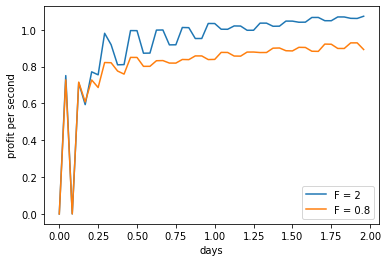

In [130]:
# plot pps against time
df1['actvpps'].plot(label=f"F = {params[0]['f']}")
df2['actvpps'].plot(label=f"F = {params[1]['f']}")
plt.xlabel('days')
plt.ylabel('profit per second')
plt.legend(loc="best")
plt.show()

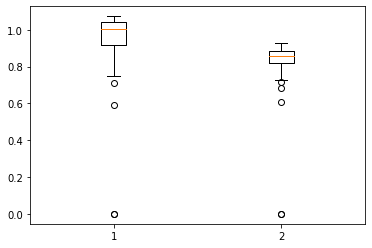

In [137]:
# boxplot of pps
plt.boxplot([df1['actvpps'], df2['actvpps']])
plt.show()

Note: the graph shows that the parameters found using Bayesian Optimisation have led to an improved performance for the PRDE trader, statistical tests need to be performed to have confidence in this result.

Note: investigate weird kink at the first two timesteps, causing statistical tests to show no significance in the difference of means.
- Theo said this could just be a quirk of the evoluation process
- A potential fix could be to run the simulation for longer so it has less of an effect on the means of the samples (worked).

In [113]:
# file = 'prde_pps_k_4_f_2_30_2.csv'
# df = pd.read_csv(file)

# df['trial_id'] = 0

# trial_id = 1
# for i in df.index:
#     df.loc[i, 'trial_id'] = trial_id
#     if i < len(df.index) - 1:
#         if df['t'][i] > df['t'][i+1]:
#             trial_id += 1

# print(trial_id)

50


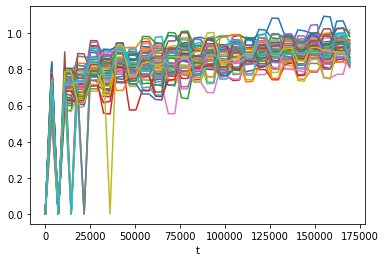

In [112]:
# for i in range(1, 51):
#     df[df['trial_id'] == i].groupby('t').mean()['actvpps'].plot()

### Pairware statistical test

In [64]:
from scipy.stats import ttest_ind, shapiro, wilcoxon

In [65]:
print(shapiro(df1['actvpps']))
print(shapiro(df2['actvpps']))

ShapiroResult(statistic=0.583897054195404, pvalue=1.9396716177677575e-10)
ShapiroResult(statistic=0.5039844512939453, pvalue=1.6496479529615193e-11)


NB: since the p-values for both sets of data are much lower than the significance level of 0.05, the null hypothesis is rejected and the datasets are not normally distributed.

In [66]:
# parametric test
ttest_ind(df1['actvpps'], df2['actvpps'])

Ttest_indResult(statistic=2.861885642378256, pvalue=0.005191021851558403)

In [67]:
# non-parametric test
wilcoxon(df1['actvpps'], df2['actvpps'])

/Users/finnformica/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_morestats.py:3337: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


WilcoxonResult(statistic=3.0, pvalue=4.2956093773375736e-09)